In [3]:
%matplotlib inline
import matplotlib.pyplot as plt #plotting
import numpy as np #array handling
import PIL
from PIL import Image #image loading
import pandas as pd
from scipy import signal #convolution

In [13]:
def generate_gabor(size, shift, sigma, rotation, phase_shift, frequency):
    radius = (int((size[0]/2.0)), int((size[1]/2.0)))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    x = x - int(shift[0])
    y = y - int(shift[1])
    x = x * frequency
    y = y * frequency
    tmp = x * np.cos(rotation) + y * np.sin(rotation) + phase_shift
    radius = (int(size[0]/2.0), int(size[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    
    x = x - int(shift[0])
    y = y - int(shift[1])
    x1 = x * np.cos(rotation) + y * np.sin(rotation)
    y1 = -x * np.sin(rotation) + y * np.cos(rotation)
    
    sinusoid = np.cos(tmp)
    
    gauss = np.e * np.exp(np.negative(0.5 * ((x1**2 / sigma[0]**2) + (y1**2 / sigma[1]**2)))) 
    gauss = gauss / 2*np.pi * sigma[0] * sigma[1]
    
    gabor = gauss * sinusoid
    return gabor

def open_norm(path,verbose=False):
    raw = np.array(Image.open(path).convert("L"))
    norm = (raw - np.mean(raw)) / np.std(raw)
    
    if verbose:
        return raw, norm
    else:
        return norm
    
def linear_convolution(center, slide): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    plt.imshow(padded_slide,origin="lower")
    plt.show()
    estimate = np.empty([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    plt.plot(np.abs(estimate))
    plt.show()
    print(np.argmax(np.abs(estimate)))
    
def double_convolve(normal, shifted, image, pupillary_distance):
    
    normal_convolved = signal.convolve2d(image, normal, boundary='symm', mode='same')
    shifted_convolved = signal.convolve2d(image, shifted, boundary='symm', mode='same')
    


    normal_convolved = normal_convolved[0:,0:-pupillary_distance]
    shifted_convolved = shifted_convolved[0:,pupillary_distance:]
    
    diff = np.subtract(normal_convolved, shifted_convolved)
    mul = normal_convolved * shifted_convolved
    #plt.imshow(mul,cmap="nipy_spectral")
    #plt.show()
    
    low_values_flags = mul <= mul.max()*0.5  # Where values are low
    mul[low_values_flags] = 0  # All low values set to 0
    return mul
def rate_filter(path):
    rating = 0
    raw = Image.open(path, 'r')
    rgb = raw.convert('RGB')
    for x in np.arange(50, 250, 1):
        for y in np.arange(0, 250, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
                
    for x in np.arange(50, 250, 1):
        for y in np.arange(300, 500, 1):
            r, g, b, = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
                
    for x in np.arange(350, 550, 1):
        for y in np.arange(150, 350):
            r, g, b, = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
    for x in np.arange(0, 50, 1):
        for y in np.arange(0, 530, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1
    for x in np.arange(250, 600, 1):
        for y in np.arange(0, 150, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1;
    for x in np.arange(250, 600, 1):
        for y in np.arange(350, 530, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1
    return rating
    
def rate(convolved):
    rating = 0
    sv = PIL.Image.fromarray(convolved)
    rgb = sv.convert('RGB')
    for y in np.arange(50, 250, 1):
        for x in np.arange(0, 250, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
                
    for y in np.arange(50, 250, 1):
        for x in np.arange(300, 500, 1):
            r, g, b, = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
                
    for y in np.arange(350, 550, 1):
        for x in np.arange(150, 350):
            r, g, b, = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating += 1
    for y in np.arange(0, 50, 1):
        for x in np.arange(0, 530, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1
    for y in np.arange(250, 600, 1):
        for x in np.arange(0, 150, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1;
    for y in np.arange(250, 600, 1):
        for x in np.arange(350, 530, 1):
            r, g, b = rgb.getpixel((int(x), int(y)))
            if r != 0 and g != 0 and b != 0:
                rating -= 1
    return rating

Left Gabor 1


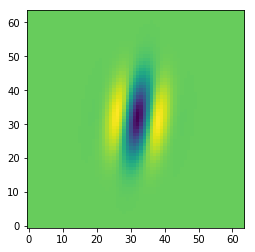

Right Gabor 1


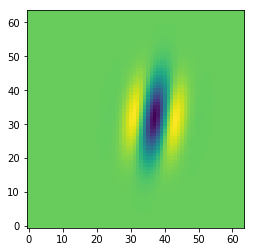

Activity Map 1


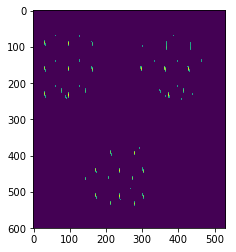

Rating: 1696
Left Gabor 2


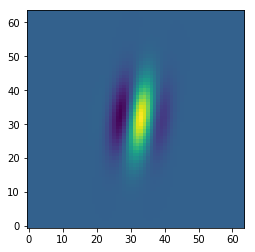

Right Gabor 2


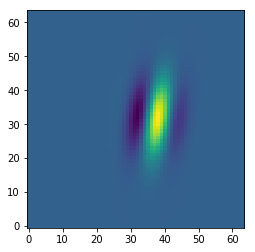

Activity Map 2


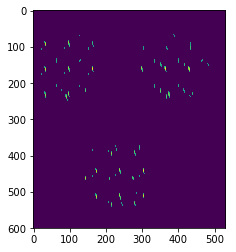

Rating: 2331


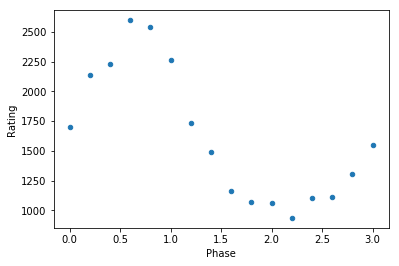

Keeping all other parameters constant, phase was changed from a range of 0to 3.14 (pi) and the binocular filters were rated.
The greatest rating was  2597  at  0.6  radians


In [14]:
"""
Example 1: Differences in activity maps of Gabor Filters with different phases
Keeping all other parameters the same, the first set of Gabors has a phase of 3.14 while the second has .5
"""

image = open_norm("shift5_70patch.png",verbose=False)
norm = generate_gabor((64, 64),(0.0, 0),(4.5, 7.59),3.0,3.14,0.4)
static = norm
plt.imshow(static, origin="lower")
print("Left Gabor 1")
plt.show()
rescaled = (255.0 / static.max() * (static - static.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/LGabor1.png")

shifted = generate_gabor((64, 64),(5.0, 0),(4.5, 7.59),3.0,3.14,0.4)
static = shifted
plt.imshow(static, origin="lower")
print("Right Gabor 1")
plt.show()
rescaled = (255.0 / static.max() * (static - static.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/RGabor1.png")

test = double_convolve(norm, shifted, image,70)
plt.imshow(test)
print("Activity Map 1")
plt.show()

rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/ActivityMap1.png")

#rate_filter("depth_perception1.png")
print("Rating:", rate(rescaled))

norm = generate_gabor((64, 64),(0.0, 0),(4.5, 7.59),3.0,.5,0.4)
static = norm
plt.imshow(static, origin="lower")
print("Left Gabor 2")
plt.show()
rescaled = (255.0 / static.max() * (static - static.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/LGabor2.png")

shifted = generate_gabor((64, 64),(5.0, 0),(4.5, 7.59),3.0,.5,0.4)
static = shifted
plt.imshow(static, origin="lower")
print("Right Gabor 2")
plt.show()
rescaled = (255.0 / static.max() * (static - static.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/RGabor2.png")

test = double_convolve(norm, shifted, image,70)
plt.imshow(test)
print("Activity Map 2")
plt.show()

rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
sv.save("example1/ActivityMap2.png")

#rate_filter("depth_perception2.png")
print("Rating:",rate(rescaled))

#plotting
phase_array = []
rating_array = []
g1, g2 = 0.0, 0;
for phase in np.arange(0, 3.14, .2):
    str(phase)[:4]
    phase_array.append(phase)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),3.0,phase,0.4)
    shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),3.0,phase,0.4)
    test = double_convolve(norm, shifted, image,70)
    rating = rate(test)
    rating_array.append(rating)
    if rating > g2:
        g2 = rating
        g1 =phase
ser = pd.Series(index=phase_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['Phase', 'Rating']
df.plot(kind='scatter', x = 'Phase', y = 'Rating')
plt.show()
print("Keeping all other parameters constant, phase was changed from a range of 0"
      "to 3.14 (pi) and the binocular filters were rated.")
print("The greatest rating was ", g2, " at ", g1," radians")

Left Gabor 1.0 , Rotation: 0.0


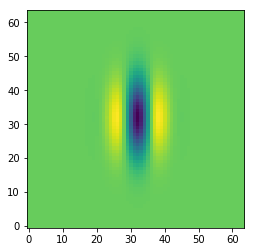

Right Gabor 1.0 , Rotation: 0.0


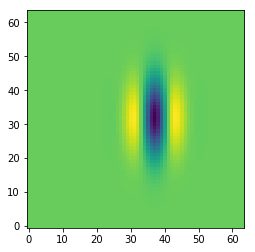

Activity Map 1.0 Rating:  2583


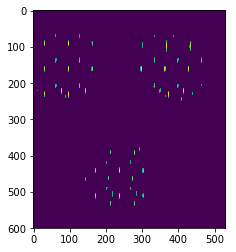

Left Gabor 2.0 , Rotation: 0.1


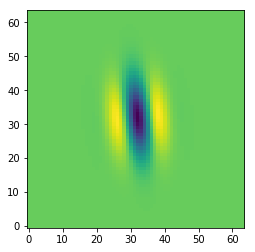

Right Gabor 2.0 , Rotation: 0.1


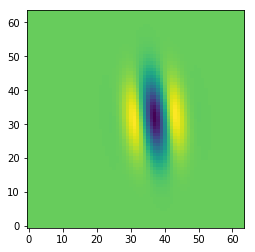

Activity Map 2.0 Rating:  2383


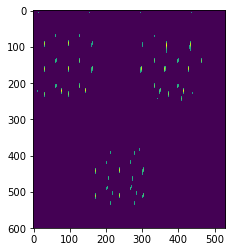

Left Gabor 3.0 , Rotation: 0.2


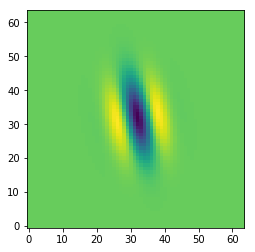

Right Gabor 3.0 , Rotation: 0.2


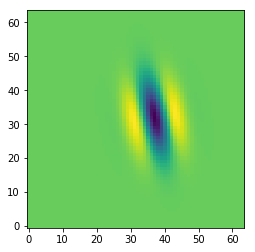

Activity Map 3.0 Rating:  2221


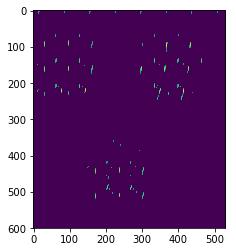

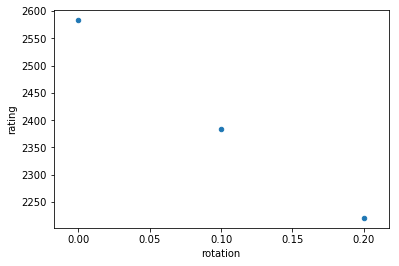

The greatest rating was  2667  at  0.8  radians


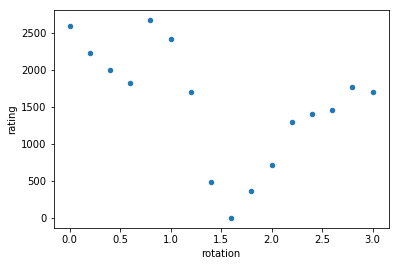

In [15]:
"""
Example 2: Differences in Activity Maps of Gabor filters with different rotations
"""

image = open_norm("shift5_70patch.png",verbose=False)
rotation_array = []
rating_array = []

for rotation in np.arange(0.0, .3, .1):
    str(rotation)[:4]
    ra = rotation / .1 + 1
    rotation_array.append(rotation)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),rotation,3.14,0.4)
    static = norm
    plt.imshow(static, origin="lower")
    print("Left Gabor", rotation / .1 + 1,", Rotation:" ,rotation)
    plt.show()
    
    shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),rotation,3.14,0.4)
    static = shifted
    plt.imshow(static, origin="lower")
    print("Right Gabor", rotation / .1 + 1,", Rotation:" ,rotation)
    plt.show()
   
    test = double_convolve(norm, shifted, image,70)
    rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
    print("Activity Map", rotation /.1 + 1, "Rating: ", rate(test))
    sv = PIL.Image.fromarray(rescaled)
    plt.imshow(test)
    plt.show()
    rating_array.append(rate(test))
ser = pd.Series(index=rotation_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['rotation', 'rating']
df.plot(kind='scatter', x = 'rotation', y = 'rating')
plt.show()

g1, g2 = 0.0, 0;
rotation_array = []
rating_array = []
for rotation in np.arange(0.0, 3.14, .2):
    str(rotation)[:4]
    rotation_array.append(rotation)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),rotation,3.14,0.4)
    shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),rotation,3.14,0.4)
    test = double_convolve(norm, shifted, image,70)
    rating = rate(test)
    rating_array.append(rating)
    if rating > g2:
        g2 = rating
        g1 =rotation
ser = pd.Series(index=rotation_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['rotation', 'rating']
df.plot(kind='scatter', x = 'rotation', y = 'rating')
print("The greatest rating was ", g2, " at ", g1," radians")
plt.show()


Left Gabor 1.0 , Frequency: 0.0


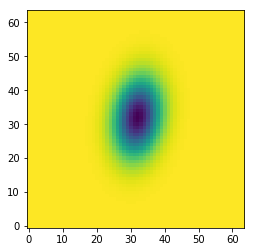

Right Gabor 1.0 , Frequency: 0.0


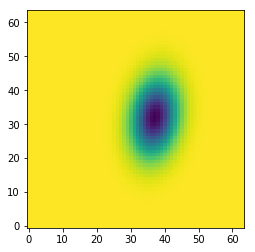

Activity Map 1.0 Rating:  -1099


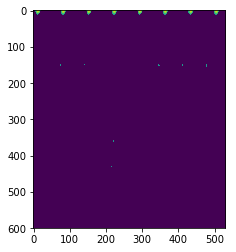

Left Gabor 2.0 , Frequency: 0.3


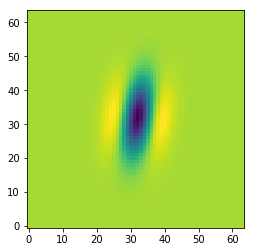

Right Gabor 2.0 , Frequency: 0.3


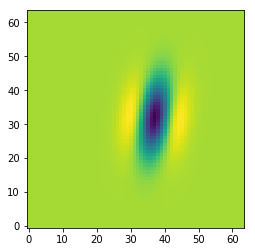

Activity Map 2.0 Rating:  2601


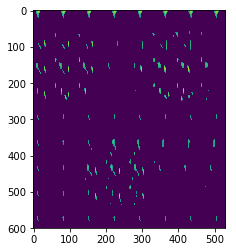

Left Gabor 3.0 , Frequency: 0.6


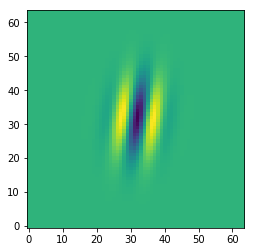

Right Gabor 3.0 , Frequency: 0.6


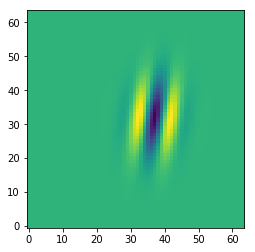

Activity Map 3.0 Rating:  1485


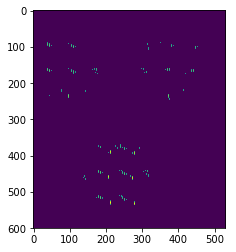

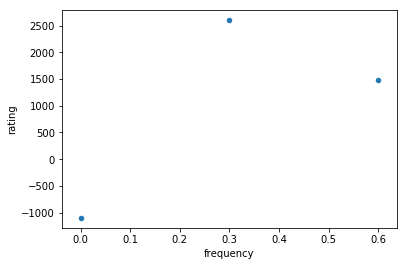

The greatest rating was  2601  at  0.3  hz


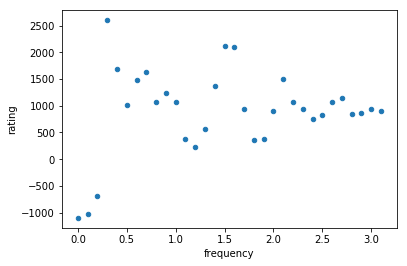

In [16]:
"""
Example 3: Differences in activity maps of Gabor Filters with different frequency
"""

image = open_norm("shift5_70patch.png",verbose=False)
frequency_array = []
rating_array = []

for frequency in np.arange(0.0, .9, .3):
    str(frequency)[:4]
    frequency_array.append(frequency)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),3.0,3.14,frequency)
    static = norm
    plt.imshow(static, origin="lower")
    print("Left Gabor", frequency / .3 + 1,", Frequency:" ,frequency)
    plt.show()
    
    shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),3.0,3.14,frequency)
    static = shifted
    plt.imshow(static, origin="lower")
    print("Right Gabor", frequency / .3 + 1,", Frequency:" ,frequency)
    plt.show()
   
    test = double_convolve(norm, shifted, image,70)
    rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
    print("Activity Map", frequency /.3 + 1, "Rating: ", rate(test))
    plt.imshow(test)
    plt.show()
    rating_array.append(rate(test))
ser = pd.Series(index=frequency_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['frequency', 'rating']
df.plot(kind='scatter', x = 'frequency', y = 'rating')
plt.show()

g1, g2 = 0.0, 0;
frequency_array = []
rating_array = []
for frequency in np.arange(0.0, 3.14, .1):
    str(frequency)[:4]
    frequency_array.append(frequency)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),3.0,3.14,frequency)
    shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),3.0,3.14,frequency)
    test = double_convolve(norm, shifted, image,70)
    rat = rate(test)
    rating_array.append(rat)
    if rat > g2:
        g2 = rat
        g1 = frequency
ser = pd.Series(index=frequency_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['frequency', 'rating']
df.plot(kind='scatter', x = 'frequency', y = 'rating')
print("The greatest rating was ", g2, " at ", g1," hz")
plt.show()

Left Gabor


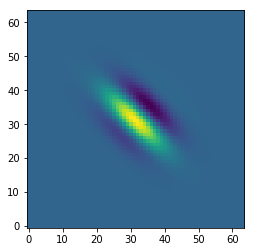

Right Gabor


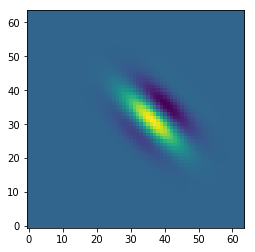

Activity Map Rating:  2145


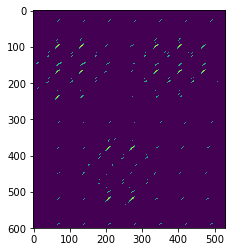

In [18]:
"""
Example 4: The best gabor filters for depth
"""

image = open_norm("shift5_70patch.png",verbose=False)
norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),0.8,0.6,0.4)
static = norm
plt.imshow(static, origin="lower")
print("Left Gabor")
plt.show()
rescaled = (255.0 / static.max() * (static - static.min())).astype(np.uint8)
sv = PIL.Image.fromarray(rescaled)
#sv.save("example1/LGabor1.png")

shifted = generate_gabor((64, 64),(5.0, 0.0),(4.5, 7.59),0.8,0.6,0.4)
static = shifted
plt.imshow(static, origin="lower")
print("Right Gabor")
plt.show()
test = double_convolve(norm, shifted, image,70)
rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
print("Activity Map", "Rating: ", rate(test))
plt.imshow(test)
plt.show()

Left Gabor 1.0 , Y Distance: 0.0


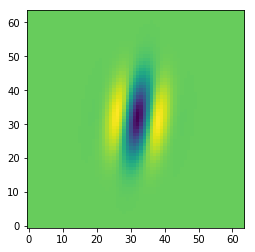

Right Gabor 1.0 , Y Distance: 0.0


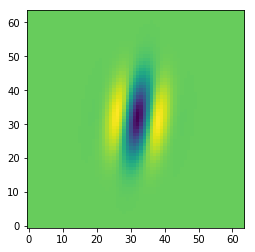

Activity Map 1.0 Rating:  -2331


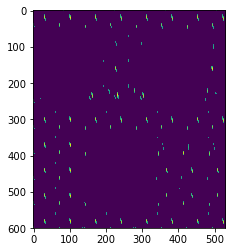

Left Gabor 2.0 , Y Distance: 10.0


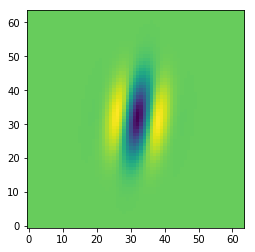

Right Gabor 2.0 , Y Distance: 10.0


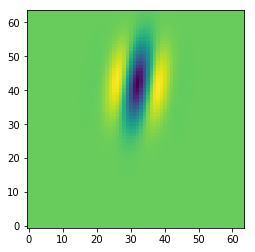

Activity Map 2.0 Rating:  -2401


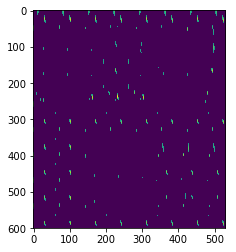

Left Gabor 3.0 , Y Distance: 20.0


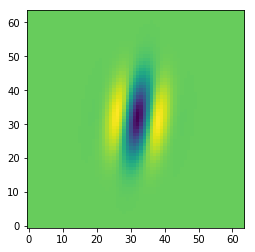

Right Gabor 3.0 , Y Distance: 20.0


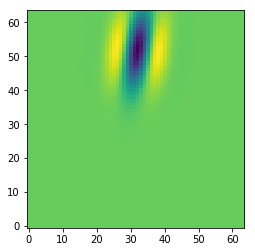

Activity Map 3.0 Rating:  -658


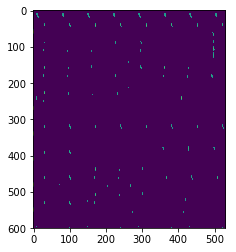

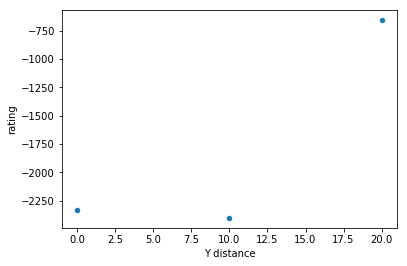

The greatest rating was  1787  at  6.0  hz


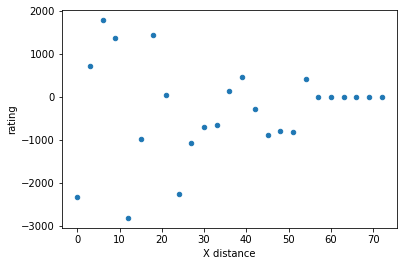

In [20]:
"""
Example 5: Shifting the binocular filters individually
"""

image = open_norm("shift5_70patch.png",verbose=False)
dist_array = []
rating_array = []

for dist in np.arange(0.0, 30, 10):
    str(dist)[:4]
    dist_array.append(dist)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),3.0,3.14,0.4)
    static = norm
    plt.imshow(static, origin="lower")
    print("Left Gabor", dist / 10 + 1,", Y Distance:" ,dist)
    plt.show()
    
    shifted = generate_gabor((64, 64),(0.0, dist),(4.5, 7.59),3.0,3.14,0.4)
    static = shifted
    plt.imshow(static, origin="lower")
    print("Right Gabor", dist / 10 + 1,", Y Distance:" ,dist)
    plt.show()
   
    test = double_convolve(norm, shifted, image,70)
    rescaled = (255.0 / test.max() * (test - test.min())).astype(np.uint8)
    print("Activity Map", dist / 10 + 1, "Rating: ", rate(test))
    plt.imshow(test)
    plt.show()
    rating_array.append(rate(test))
ser = pd.Series(index=dist_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['Y distance', 'rating']
df.plot(kind='scatter', x = 'Y distance', y = 'rating')
plt.show()

g1, g2 = 0.0, 0;
dist_array = []
rating_array = []
for dist in np.arange(0.0, 75, 3):
    str(dist)[:4]
    dist_array.append(dist)
    norm = generate_gabor((64, 64),(0.0, 0.0),(4.5, 7.59),3.0,3.14,0.4)
    shifted = generate_gabor((64, 64),(dist, 0.0),(4.5, 7.59),3.0,3.14,0.4)
    test = double_convolve(norm, shifted, image,70)
    rat = rate(test)
    rating_array.append(rat)
    if rat > g2:
        g2 = rat
        g1 = dist
ser = pd.Series(index=dist_array, data = rating_array)
df = ser.to_frame()
df.reset_index(inplace=True)
df.columns = ['X distance', 'rating']
df.plot(kind='scatter', x = 'X distance', y = 'rating')
print("The greatest rating was ", g2, " at ", g1," ")
plt.show()